In [ ]:
pip install scikit-optimize

In [ ]:
pip install imagededup

In [ ]:
pip install scikeras

In [ ]:
!pip install keras-tuner

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from imagededup.methods import PHash
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import shutil
import keras
import keras_tuner as kt
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for root, dirs, files in os.walk('/content/drive/'):
    for file in files:
        if file == 'image_data.csv':
            print(os.path.join(root, file))

/content/drive/MyDrive/image_data.csv


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/image_data.csv')
dataset

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
...,...,...,...,...
7904,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7905,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7906,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7907,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X


## 1.1 Data Organization and Understanding
Passos:
- Analisar Dados tabela do ficheiro csv
  - Verificar se tem nulos
  - Verificar se tem duplicados

- Verificar imagens duplicadas da pasta em conjunto
  - Eliminar imagens duplicas (se aplicavel)

- Dividir ficheiros da pasta unica em duas pastas (benigno e maligno)
- Analisar data distribution:
  - População de Benignos e Malignos
  - Distribuição em cada Tipo de cancro
  - Distribuição das ampliação

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path_to_image        7909 non-null   object
 1   Benign or Malignant  7906 non-null   object
 2   Cancer Type          7905 non-null   object
 3   Magnification        7905 non-null   object
dtypes: object(4)
memory usage: 247.3+ KB


# Duplicates

In [ ]:

phasher = PHash()

encodings = phasher.encode_images(image_dir='/content/drive/MyDrive/benigno_maligno/')

duplicates = phasher.find_duplicates(encoding_map=encodings)

processed_pairs = set()

def are_same_subject_and_cancer_type(filename1, filename2):
    base_filename1 = '-'.join(filename1.split('-')[:-1])  # Exclude the last part (e.g., '001.png')
    base_filename2 = '-'.join(filename2.split('-')[:-1])

    return base_filename1 == base_filename2

for key, values in duplicates.items():
    for value in values:
        pair = tuple(sorted([key, value]))
        if pair not in processed_pairs:
            print(f"Image {pair[0]} has duplicates: {pair[1]}")
            processed_pairs.add(pair)

processed_pairs_same_info = set()
for key, values in duplicates.items():
    for value in values:
        if are_same_subject_and_cancer_type(key, value):
            pair = tuple(sorted([key, value]))
            if pair not in processed_pairs_same_info:
                print(f"Image {pair[0]} has duplicate {pair[1]} with the same classification and cancer type.")
                processed_pairs_same_info.add(pair)

In [ ]:
#Delete duplicate images with the same classification and cancer type

image_folder = "/content/drive/MyDrive/benigno_maligno/"

duplicates_to_remove = [
    "SOB_B_F-14-23060AB-100-013.png",
    "SOB_B_F-14-23060AB-40-009.png",
    "SOB_B_TA-14-15275-400-009.png",
    "SOB_B_TA-14-3411F-100-011.png",
    "SOB_B_F-14-23222AB-400-010.png",
    "SOB_M_LC-14-12204-40-035.png",
    "SOB_M_LC-14-12204-40-034.png",
    "SOB_M_DC-14-9461-100-004.png",
    "SOB_M_DC-14-9461-100-040.png",
    "SOB_M_LC-14-16196-40-002.png",
    "SOB_M_DC-14-20629-400-019.png",
    "SOB_M_DC-14-13993-100-042.png",
    "SOB_M_DC-14-15792-200-005.png",
    "SOB_M_PC-14-15704-100-026.png",
]

for duplicate in duplicates_to_remove:
    file_path = os.path.join(image_folder, duplicate)
    try:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error deleting file {file_path}: {e}")

Deleted: /content/drive/MyDrive/benigno_maligno/SOB_B_F-14-23060AB-100-013.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_B_F-14-23060AB-40-009.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_B_TA-14-15275-400-009.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_B_TA-14-3411F-100-011.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_B_F-14-23222AB-400-010.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_LC-14-12204-40-035.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_LC-14-12204-40-034.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_DC-14-9461-100-004.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_DC-14-9461-100-040.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_LC-14-16196-40-002.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_DC-14-20629-400-019.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_DC-14-13993-100-042.png
Deleted: /content/drive/MyDrive/benigno_maligno/SOB_M_DC-14-15792-2

In [ ]:
dataset[dataset.isnull().any(axis=1)]

,path_to_image,Benign or Malignant,Cancer Type,Magnification
2871,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN
3093,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,NaN,NaN
3228,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN
4536,BreaKHis_v1/histology_slides/breast/malignant/...,NaN,NaN,NaN


In [ ]:
def extract_info_from_path(row):
    if pd.isnull(row['Benign or Malignant']):
        row['Benign or Malignant'] = 'Benign' if 'benign' in row['path_to_image'].lower() else 'Malignant'

    if pd.isnull(row['Cancer Type']):
        if 'mucinous_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Mucinous Carcinoma'
        elif 'ductal_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Ductal Carcinoma'
        elif 'lobular_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Lobular Carcinoma'
        elif 'papillary_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Papillary Carcinoma'
        elif 'adenosis' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Adenosis'
        elif 'tubular_adenoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Tubular Adenoma'
        elif 'fibroadenoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Fibroadenoma'
        elif 'phyllodes_tumor' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Phyllodes Tumor'

    if pd.isnull(row['Magnification']):
        if '100x' in row['path_to_image'].lower():
            row['Magnification'] = '100X'
        elif '200x' in row['path_to_image'].lower():
            row['Magnification'] = '200X'
        elif '400x' in row['path_to_image'].lower():
            row['Magnification'] = '400X'
        elif '40x' in row['path_to_image'].lower():
            row['Magnification'] = '40X'

    return row

dataset = dataset.apply(extract_info_from_path, axis=1)

print(dataset.isnull().sum())

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64


In [ ]:
dataset.describe()

,path_to_image,Benign or Malignant,Cancer Type,Magnification
count,7909,7909,7909,7909
unique,7909,2,8,4
top,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Ductal Carcinoma,100X
freq,1,5429,3451,2081


-------
Data Distribution

In [ ]:
# Directory containing images
image_dir = '/content/drive/MyDrive/benigno_maligno/'

labels = []
cancer_types = []
magnifications = []

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        parts = filename.split('_')

        if len(parts) < 3:
            print(f"Skipping invalid filename: {filename}")
            continue

        try:
            label = parts[1]
            labels.append('Benign' if label == 'B' else 'Malignant')

            # Extract Cancer Type
            cancer_type = parts[2].split('-')[0]
            if cancer_type.lower() == 'mc':
                cancer_types.append('Mucinous_Carcinoma')
            elif cancer_type.lower() == 'dc':
                cancer_types.append('Ductal_Carcinoma')
            elif cancer_type.lower() == 'lc':
                cancer_types.append('Lobular_Carcinoma')
            elif cancer_type.lower() == 'pc':
                cancer_types.append('Papillary_Carcinoma')
            elif cancer_type.lower() == 'a':
                cancer_types.append('Adenosis')
            elif cancer_type.lower() == 'ta':
                cancer_types.append('Tubular_Adenoma')
            elif cancer_type.lower() == 'f':
                cancer_types.append('Fibroadenoma')
            elif cancer_type.lower() == 'pt':
                cancer_types.append('Phyllodes_Tumor')
            else:
                raise ValueError(f"Unknown Cancer Type in: {filename}")

            # Extract Magnification
            magnification = parts[2].split('-')[3]
            magnifications.append(magnification)

        except Exception as e:
            print(f"Error processing file: {filename} - {e}")


data = pd.DataFrame({
    'Label': labels,
    'CancerType': cancer_types,
    'Magnification': magnifications
})

print(data.head())

    Label    CancerType Magnification
0  Benign  Fibroadenoma           100
1  Benign  Fibroadenoma           100
2  Benign  Fibroadenoma           100
3  Benign  Fibroadenoma           100
4  Benign  Fibroadenoma           100


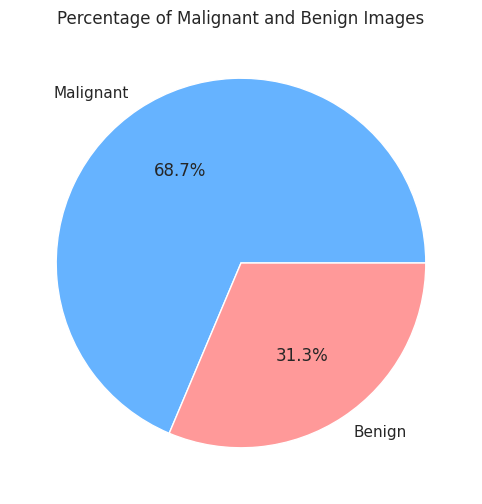

<ipython-input-14-1ce197c2de22>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='CancerType', order=data['CancerType'].value_counts().index, palette='viridis')


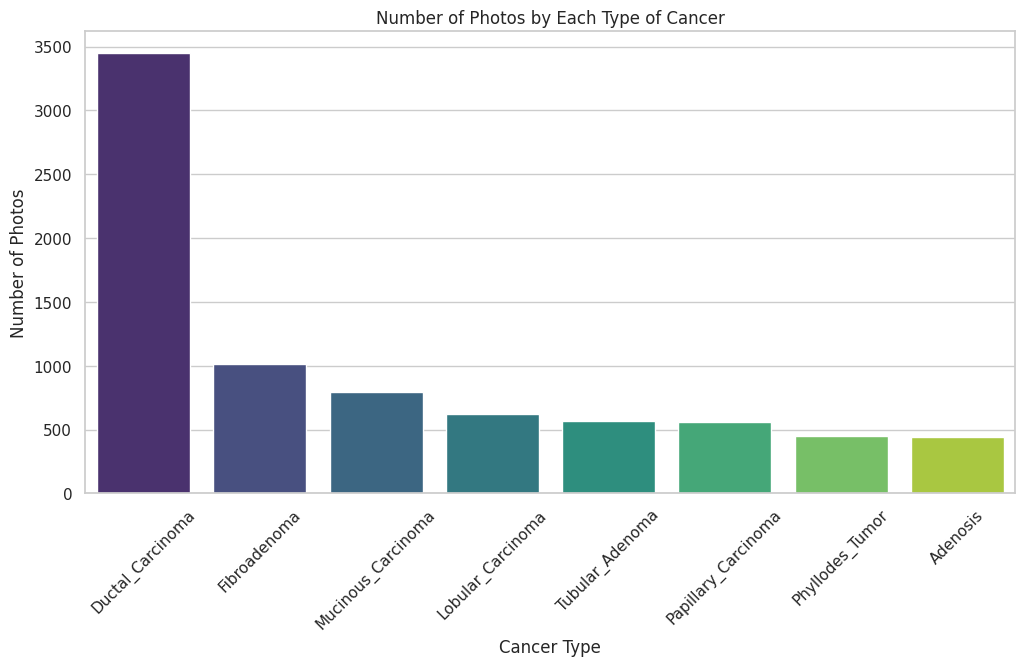

<ipython-input-14-1ce197c2de22>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Magnification', order=sorted(data['Magnification'].unique()), palette='magma')


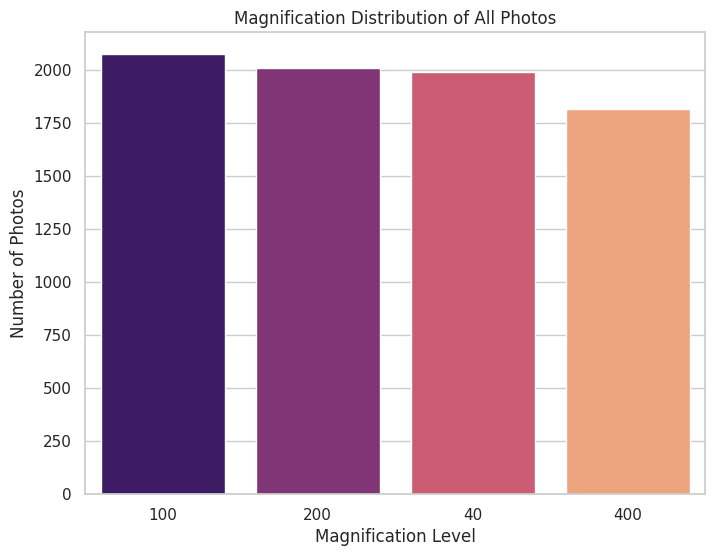

In [ ]:
sns.set(style="whitegrid")

# Plot 1: Percentage of Malignant and Benign Images
plt.figure(figsize=(8, 6))
label_counts = data['Label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Percentage of Malignant and Benign Images')
plt.show()

# Plot 2: Number of Photos by Each Type of Cancer
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='CancerType', order=data['CancerType'].value_counts().index, palette='viridis')
plt.title('Number of Photos by Each Type of Cancer')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Photos')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Magnification Distribution of All Photos
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Magnification', order=sorted(data['Magnification'].unique()), palette='magma')
plt.title('Magnification Distribution of All Photos')
plt.xlabel('Magnification Level')
plt.ylabel('Number of Photos')
plt.show()

## 1.2 Data Processing
Passos:
- Carregar imagens no documento
- Redimensionar imagens de acordo com a dimensão que pretendemos utilizar no modelo
- Normalizar todas as imagens para a mesma escala de forma a acelerar o processo de treino
- Verificar se é necessário realizar

In [ ]:
original_dataset_dir = '/content/drive/MyDrive/benigno_maligno'

In [ ]:
# Path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/drive/MyDrive/benigno_maligno'

# Directory where you'll store your smaller dataset
base_dir = '/content/drive/MyDrive/benign_malignant_small'
os.mkdir(base_dir)

# Directories for the training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with training benign pictures
train_benign_dir = os.path.join(train_dir, 'benign')
os.mkdir(train_benign_dir)

# Directory with training malignant pictures
train_malignant_dir = os.path.join(train_dir, 'malignant')
os.mkdir(train_malignant_dir)

# Directory with validation benign pictures
validation_benign_dir = os.path.join(validation_dir, 'benign')
os.mkdir(validation_benign_dir)

# Directory with validation malignant pictures
validation_malignant_dir = os.path.join(validation_dir, 'malignant')
os.mkdir(validation_malignant_dir)

# Directory with test benign pictures
test_benign_dir = os.path.join(test_dir, 'benign')
os.mkdir(test_benign_dir)

# Directory with test malignant pictures
test_malignant_dir = os.path.join(test_dir, 'malignant')
os.mkdir(test_malignant_dir)

In [ ]:
def copy_files(file_list, label_list, dest_dir_benign, dest_dir_malignant):
    for file, label in zip(file_list, label_list):
        src = os.path.join(original_dataset_dir, file)

        # Copy the image to the destination folder
        if label == 0:  # Benign
            dest = os.path.join(dest_dir_benign, file)
        else:  # Malignant
            dest = os.path.join(dest_dir_malignant, file)

        shutil.copy(src, dest)

In [ ]:
benign_images = []
malignant_images = []

for file in os.listdir(original_dataset_dir):
    if file.startswith('SOB_B'):
        benign_images.append(file)

    elif file.startswith('SOB_M'):
        malignant_images.append(file)

image_files = benign_images + malignant_images
labels = [0] * len(benign_images) + [1] * len(malignant_images)  # 0 for benign, 1 for malignant

image_files = np.array(image_files)
labels = np.array(labels)

shuffled_indices = np.random.permutation(len(image_files))
image_files = image_files[shuffled_indices]
labels = labels[shuffled_indices]

In [ ]:
print(image_files.shape)
print(labels.shape)

(7895,)
(7895,)


In [ ]:
# Step 1: Split into Train (80%) and Temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=42
)

# Step 2: Split Temp into Validation (10%) and Test (10%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=42
)

# Output the sizes of each set
print(f"Training set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

# Verify class distributions
print("Class distribution in Train:", np.bincount(labels[train_idx]))
print("Class distribution in Validation:", np.bincount(labels[val_idx]))
print("Class distribution in Test:", np.bincount(labels[test_idx]))

Training set size: 6316
Validation set size: 789
Test set size: 790
Class distribution in Train: [1980 4336]
Class distribution in Validation: [247 542]
Class distribution in Test: [248 542]


In [ ]:
# Use the indices to split files for training, validation, and testing
train_files = image_files[train_idx]
train_labels = labels[train_idx]

val_files = image_files[val_idx]
val_labels = labels[val_idx]

test_files = image_files[test_idx]
test_labels = labels[test_idx]

In [ ]:
# Copy files to the respective directories
print('Copying train files...')
copy_files(train_files, train_labels, train_benign_dir, train_malignant_dir)
print('Copying validation files...')
copy_files(val_files, val_labels, validation_benign_dir, validation_malignant_dir)
print('Copying test files...')
copy_files(test_files, test_labels, test_benign_dir, test_malignant_dir)

print("Image files successfully split and copied into directories.")

Copying train files...
Copying validation files...
Copying test files...
Image files successfully split and copied into directories.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/benign_malignant_small/train'
validation_dir = '/content/drive/MyDrive/benign_malignant_small/validation'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        seed=42,
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        seed=42,
        shuffle=False)

Found 6316 images belonging to 2 classes.
Found 789 images belonging to 2 classes.


In [ ]:
print(len(train_files))
print(len(val_files))


6316
789


In [ ]:
for batch, labels in train_generator:
    print(batch.shape, labels.shape)
    break

(32, 150, 150, 3) (32,)


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

# MODEL 1

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', patience=5, restore_best_weights=True)]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC', 'Accuracy']
)

steps_per_epoch = len(train_files) // train_generator.batch_size
validation_steps = len(val_files) // validation_generator.batch_size

history = model.fit(
      train_generator,
      epochs=10,
      #steps_per_epoch=steps_per_epoch,
      #callbacks = callbacks_list,
      validation_data=validation_generator,
      #validation_steps = validation_steps
      )

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 129s 599ms/step - AUC: 0.8736 - Accuracy: 0.8199 - Precision: 0.8507 - Recall: 0.8909 - loss: 0.4852 - val_AUC: 0.4962 - val_Accuracy: 0.6869 - val_Precision: 0.6918 - val_Recall: 0.9815 - val_loss: 6.0545
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 143s 620ms/step - AUC: 0.9201 - Accuracy: 0.8594 - Precision: 0.8881 - Recall: 0.9097 - loss: 0.3346 - val_AUC: 0.7248 - val_Accuracy: 0.7288 - val_Precision: 0.7265 - val_Recall: 0.9705 - val_loss: 0.8531
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 119s 585ms/step - AUC: 0.9486 - Accuracy: 0.8901 - Precision: 0.9189 - Recall: 0.9222 - loss: 0.2659 - val_AUC: 0.6244 - val_Accuracy: 0.5970 - val_Precision: 0.7772 - val_Recall: 0.5793 - val_loss: 1.1211
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 119s 587ms/step - AUC: 0.9607 - Accuracy: 0.8970 - Precision: 0.9263 - Recall: 0.9225 - loss: 0.2360 - val_AUC: 0.6757 - val_Accuracy: 0.6895 - val_Precision: 0.6901 - val_Recall: 0.9945 - val_loss: 1.1886
Epoch 5/10
198/1

In [ ]:
# Check the size and the batches in validation_generator
print(f"Validation Generator Samples: {len(validation_generator.filenames)}")
print(f"Validation Generator Batch Size: {validation_generator.batch_size}")
print(f"Validation Generator Steps per Epoch: {len(validation_generator.filenames) // validation_generator.batch_size}")

# Check if validation data is being generated correctly by inspecting a sample
x_val_test, y_val_test = next(validation_generator)  # Get one batch of validation data
print(f"Sample Validation Batch Shape: {x_val_test.shape}")  # Should print (batch_size, height, width, channels)
print(f"Sample Validation Labels: {y_val_test}")

Validation Generator Samples: 789
Validation Generator Batch Size: 16
Validation Generator Steps per Epoch: 49
Sample Validation Batch Shape: (16, 150, 150, 3)
Sample Validation Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
counter = 0
max_batches_to_print = 50

for batch, labels in validation_generator:
    print(f"Labels in batch {counter + 1}: {labels}")
    counter += 1
    if counter >= max_batches_to_print:
        break

In [ ]:
for batch, labels in validation_generator:
    print(batch, labels)
    break

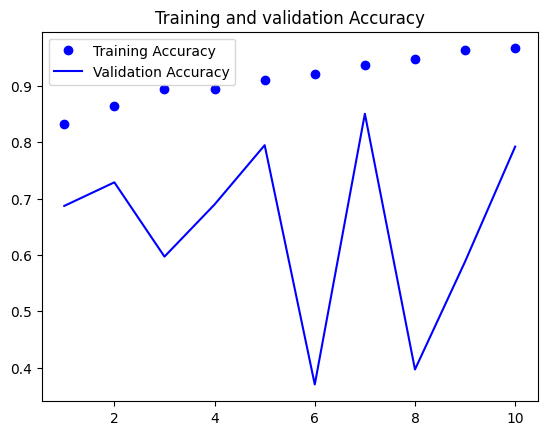

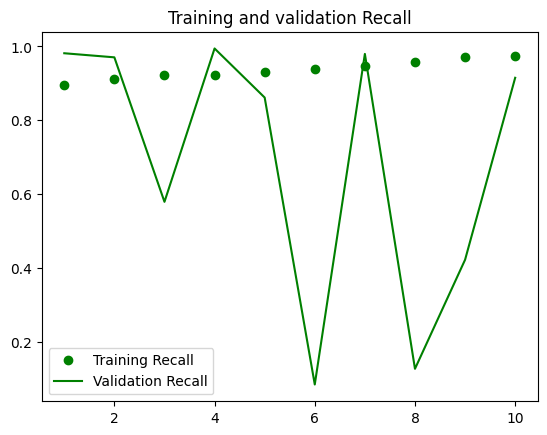

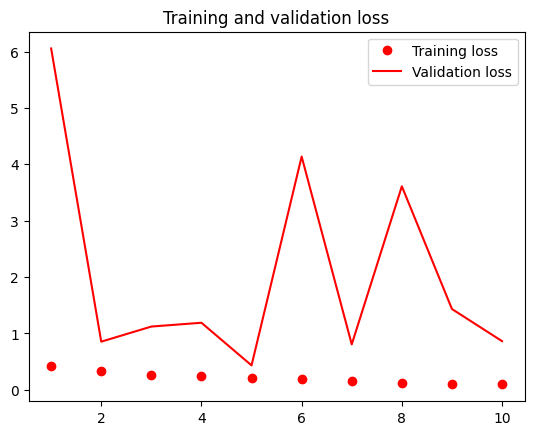

In [ ]:
accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['Recall']
val_recall = history.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/benign_malignant_small_1st.h5')

In [ ]:
def build_classifier(hp):
    classifier = models.Sequential()
    classifier.add(layers.InputLayer(input_shape=(150,150,3)))
    classifier.add(layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(layers.MaxPooling2D((2, 2)))
    classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
    classifier.add(layers.MaxPooling2D((2, 2)))
    classifier.add(layers.Flatten())

    classifier.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    classifier.add(layers.Dense(units=1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Recall'])

    batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
    epochs = hp.Int('epochs', min_value=10, max_value=30, step=10)

    return classifier

tuner = kt.BayesianOptimization(
    build_classifier,
    objective='val_Recall',
    max_trials=5,
    directory='tuner_results',
    project_name='cnn_finetuning'
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    #steps_per_epoch=len(train_generator),
    epochs=5,
    #validation_steps = len(validation_generator)
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
print("Best Optimizer:", best_hp.get('optimizer'))
print("Best Batch Size:", best_hp.get('batch_size'))
print("Best Number of Epochs:", best_hp.get('epochs'))
print(best_model.summary())

Trial 5 Complete [00h 08m 54s]
val_Recall: 1.0

Best val_Recall So Far: 1.0
Total elapsed time: 00h 45m 02s
Best Optimizer: adam
Best Batch Size: 48
Best Number of Epochs: 20


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 480)                 │      39,813,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             481 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,833,473 (151.95 MB)

 Trainable params: 39,833,473 (151.95 MB)

 Non-trainable params: 0 (0.00 B)

None


# MODEL 2, Class_Weights, Data Augmentation and Callbacks

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


### Data Augmentation

In [ ]:
train_aug_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
train_aug_generator = train_aug_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        seed=42,
        shuffle=True)

Found 6316 images belonging to 2 classes.


### Class Weights

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_aug_generator.classes),  # Unique class labels ([0, 1])
    y=train_aug_generator.classes
)

In [ ]:
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.594949494949495, 1: 0.7283210332103321}


### Callbacks

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]

In [ ]:

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC', 'Accuracy']
)

history = model_2.fit(
      train_aug_generator,
      epochs=20,
      callbacks = callbacks_list,
      validation_data=validation_generator,
      class_weight=class_weights_dict
      )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 148s 695ms/step - AUC: 0.7410 - Accuracy: 0.7076 - Precision: 0.8344 - Recall: 0.7144 - loss: 5.2054 - val_AUC: 0.5000 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 17.0857
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 676ms/step - AUC: 0.8924 - Accuracy: 0.8007 - Precision: 0.8933 - Recall: 0.8027 - loss: 0.4234 - val_AUC: 0.5062 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 9.3658
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 672ms/step - AUC: 0.9137 - Accuracy: 0.8310 - Precision: 0.9065 - Recall: 0.8393 - loss: 0.3751 - val_AUC: 0.5198 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 1.0099
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 676ms/step - AUC: 0.8734 - Accuracy: 0.7846 - Precision: 0.8869 - Recall: 0.7799 - loss: 0.4971 - val_AUC: 0.7745 - val_Accuracy: 0.7250 - val_Precision: 0.7235 - val_Recall: 0.9705 - val_loss: 0.6630
Epoch 5/20
198/198 ━━━━━━━

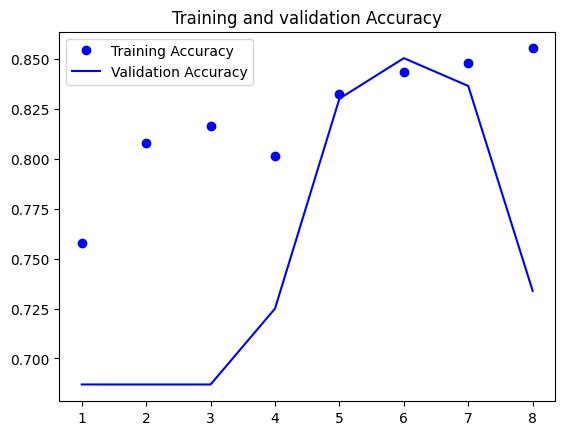

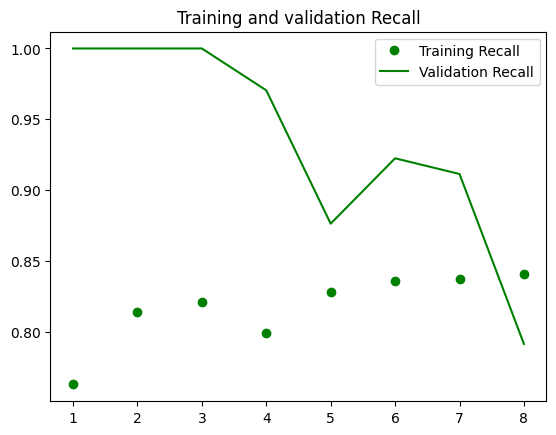

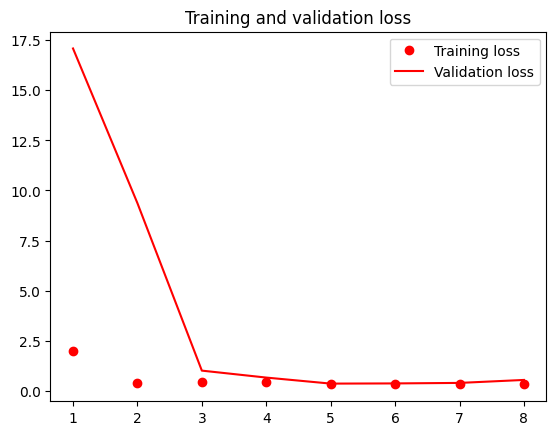

In [ ]:
accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['Recall']
val_recall = history.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_2.save('/content/drive/MyDrive/benign_malignant_small_2nd.h5')

## MODEL 3, L2 Regularization Dropout and Class weights

In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape=(150, 150, 3)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(480, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
train_aug_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
train_aug_generator = train_aug_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=48,
        class_mode='binary',
        seed=42,
        shuffle=True)

Found 6316 images belonging to 2 classes.


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance the classes
    classes=np.unique(train_aug_generator.classes),  # Unique class labels (e.g., [0, 1])
    y=train_aug_generator.classes  # Array of class labels for the training set
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.594949494949495, 1: 0.7283210332103321}


In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]

In [ ]:

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC', 'Accuracy']
)

history_3 = model_3.fit(
      train_aug_generator,
      epochs=20,
      callbacks = callbacks_list,
      validation_data=validation_generator,
      class_weight=class_weights_dict
      )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - AUC: 0.7793 - Accuracy: 0.7283 - Precision: 0.8607 - Recall: 0.7274 - loss: 5.4431 - val_AUC: 0.5000 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 20.2244
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 135s 973ms/step - AUC: 0.9029 - Accuracy: 0.8245 - Precision: 0.9006 - Recall: 0.8385 - loss: 1.5022 - val_AUC: 0.5000 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 6.0540
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 134s 967ms/step - AUC: 0.9092 - Accuracy: 0.8261 - Precision: 0.9163 - Recall: 0.8220 - loss: 1.3421 - val_AUC: 0.5651 - val_Accuracy: 0.6869 - val_Precision: 0.6869 - val_Recall: 1.0000 - val_loss: 2.6661
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 134s 963ms/step - AUC: 0.9137 - Accuracy: 0.8346 - Precision: 0.9174 - Recall: 0.8351 - loss: 1.1909 - val_AUC: 0.8501 - val_Accuracy: 0.7858 - val_Precision: 0.8693 - val_Recall: 0.8100 - val_loss: 1.5038
Epoch 5/20
132/132 ━━━━━━━━━━

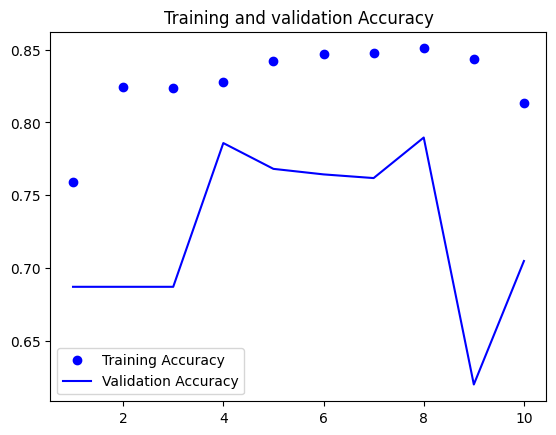

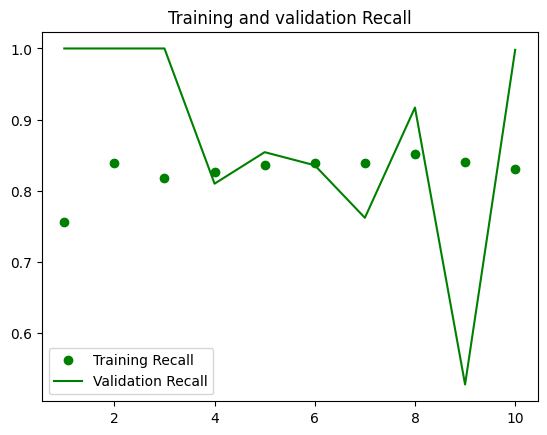

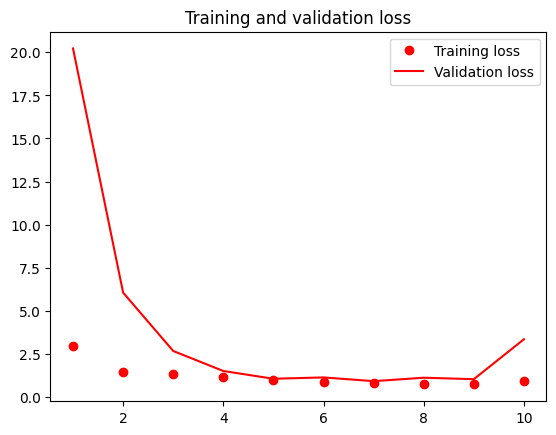

In [ ]:
accuracy = history_3.history['Accuracy']
val_accuracy = history_3.history['val_Accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
recall = history_3.history['Recall']
val_recall = history_3.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_3.save('/content/drive/MyDrive/benign_malignant_small_3rd.h5')

# Test Model 3

In [ ]:
test_dir = '/content/drive/MyDrive/benign_malignant_small/test'

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=48,
    class_mode='binary'
)

Found 790 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy, test_recall, test_auc, test_precision= model_3.evaluate(test_generator)
print(f"Test Recall: {test_recall}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 689ms/step - AUC: 0.8509 - Accuracy: 0.7581 - Precision: 0.8810 - Recall: 0.7508 - loss: 0.9354
Test Recall: 0.8734177350997925
Test Loss: 0.924105167388916
Test Accuracy: 0.7638376355171204
Test AUC: 0.8527668118476868
Test Precision: 0.7620252966880798


In [ ]:
y_true = test_generator.classes

y_pred_probabilities = model_3.predict(test_generator)
y_pred = (y_pred_probabilities > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step


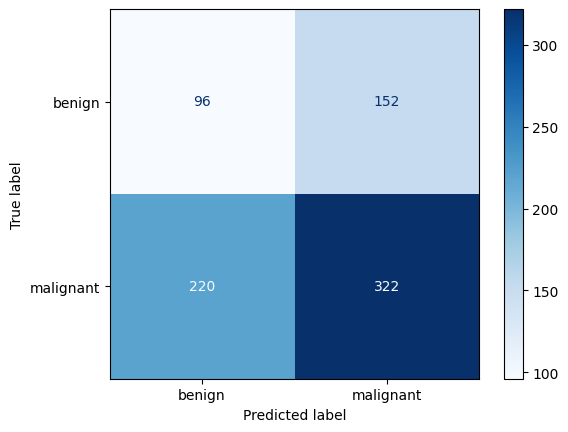

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')

# Test Model 2

In [ ]:
test_loss_2, test_accuracy_2, test_recall_2, test_auc_2, test_precision_2= model_2.evaluate(test_generator)
print(f"Test Recall: {test_recall_2}")
print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")
print(f"Test AUC: {test_auc_2}")
print(f"Test Precision: {test_precision_2}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 687ms/step - AUC: 0.9083 - Accuracy: 0.8304 - Precision: 0.9015 - Recall: 0.8541 - loss: 0.3779
Test Recall: 0.8754789233207703
Test Loss: 0.4103040099143982
Test Accuracy: 0.8431734442710876
Test AUC: 0.8898382782936096
Test Precision: 0.8101266026496887


In [ ]:

y_pred_probabilities_2 = model_2.predict(test_generator)
y_pred_2 = (y_pred_probabilities_2 > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step


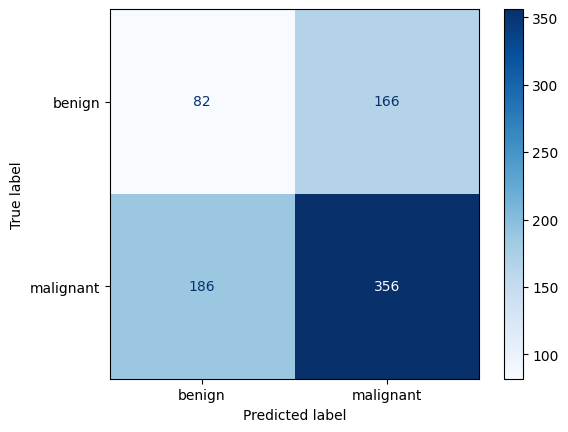

In [ ]:
cm = confusion_matrix(y_true, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')

# Test Model 1

In [ ]:
model_1 = load_model('/content/drive/MyDrive/benign_malignant_small_1st.h5')

In [ ]:
test_loss_1, test_accuracy_1, test_recall_1, test_auc_1, test_precision_1 = model_1.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")
print(f"Test Recall: {test_recall_1}")
print(f"Test AUC: {test_auc_1}")
print(f"Test Precision: {test_precision_1}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 686ms/step - accuracy: 0.1123 - auc_1: 0.8495 - loss: 0.8117 - precision_1: 0.8303 - recall_3: 0.9516
Test Loss: 0.8524733781814575
Test Accuracy: 0.9428044557571411
Test Recall: 0.8228663206100464
Test AUC: 0.8400041460990906
Test Precision: 0.09746835380792618


In [ ]:

y_pred_probabilities_1 = model_1.predict(test_generator)
y_pred_1 = (y_pred_probabilities_1 > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step


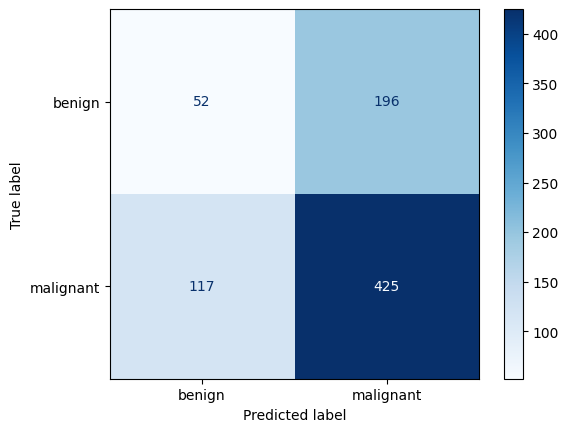

In [ ]:
cm = confusion_matrix(y_true, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')